<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [51]:
#Importing Libraries

import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [3]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [7]:
df_final_train.columns
df_final_train.sample(5)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
28717,1065224,1089085,1,0,0.230769,0.041996,0.377964,9,9,7,...,2.138879e-11,7.707624e-14,2.358701e-13,1.250468e-14,-2.899475e-15,7.241227e-14,1.157542e-12,6.504260e-12,1.967107e-13,3.713690e-16
27819,1249327,1578943,1,0,0.172775,0.023904,0.300497,196,134,90,...,-9.280774e-11,1.173556e-09,-7.131169e-13,1.965942e-02,1.407556e-13,-7.169089e-13,-3.516788e-10,-1.047432e-08,-2.890610e-12,8.067219e-02
92354,686632,1284361,0,0,0.000000,0.000000,0.000000,1,2,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.375805e-22,2.121909e-21,6.420414e-20,6.926887e-22,-7.675343e-22,-3.613155e-22
35980,498289,1732479,1,0,0.045455,0.074536,0.114708,3,19,4,...,4.681435e-10,9.470136e-12,1.785177e-11,5.020871e-14,-2.242198e-13,1.016657e-11,2.119183e-12,2.035195e-12,5.572053e-13,1.778798e-15
67395,1311359,390217,0,0,0.000000,0.000000,0.000000,0,6,1,...,6.311099e-11,1.819855e-12,1.059292e-11,1.784961e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [11]:
if os.path.isfile('train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


### Preferential Attachment feature

In [20]:
def PrefAttachment(a,b):
    try:
        mult = len(list(train_graph.predecessors(a))) * len(list(train_graph.predecessors(b)))
        return mult
    except:
        return 0

In [21]:
#adding new feature of preferential attachment to the dataset
df_final_train['pref_attachment'] = df_final_train.apply(lambda row:
                                            PrefAttachment(row['source_node'],row['destination_node']),axis=1)
df_final_test['pref_attachment'] = df_final_test.apply(lambda row:
                                            PrefAttachment(row['source_node'],row['destination_node']),axis=1)

In [23]:
df_final_test.sample(5)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_attachment
10246,1764063,90407,1,0,0.052632,0.051031,0.100125,12,19,21,...,8.607366e-11,1.260107e-10,6.176012e-13,-1.820895e-09,2.127048e-09,4.759990e-10,1.369629e-10,2.647054e-10,6.481495e-12,288
18775,979299,1176720,1,0,0.000000,0.288675,0.000000,6,1,6,...,1.631234e-21,4.193734e-23,-2.076080e-21,5.601581e-21,-1.439368e-21,6.743790e-21,3.990830e-21,2.520695e-22,-3.881356e-21,18
49061,1719797,426275,0,0,0.000000,0.000000,0.000000,0,1,3,...,2.680241e-17,9.789288e-20,-1.194643e-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0
36683,309475,869304,0,0,0.000000,0.000000,0.000000,2,4,0,...,8.705262e-13,3.430645e-13,2.769591e-14,-8.843197e-16,6.449596e-15,5.123909e-13,2.224978e-13,7.628338e-15,9.534099e-17,12
27603,1784062,420237,0,0,0.000000,0.000000,0.000000,3,1,4,...,0.000000e+00,0.000000e+00,0.000000e+00,-1.958632e-13,2.645326e-13,6.112403e-13,7.863741e-14,3.126846e-13,1.901776e-16,0


### SVD Dot Product features

In [29]:
def svd_dot_u(row):
    dot_u = np.dot([row['svd_u_s_1'],row['svd_u_s_2'],row['svd_u_s_3'],row['svd_u_s_4'],row['svd_u_s_5'],row['svd_u_s_6']],
                  [row['svd_u_d_1'],row['svd_u_d_2'],row['svd_u_d_3'],row['svd_u_d_4'],row['svd_u_d_5'],row['svd_u_d_6']])
    return dot_u

def svd_dot_v(row):
    dot_v = np.dot([row['svd_v_s_1'],row['svd_v_s_2'],row['svd_v_s_3'],row['svd_v_s_4'],row['svd_v_s_5'],row['svd_v_s_6']],
                  [row['svd_v_d_1'],row['svd_v_d_2'],row['svd_v_d_3'],row['svd_v_d_4'],row['svd_v_d_5'],row['svd_v_d_6']])
    return dot_v

In [30]:
#adding new features of dot product to the dataset
df_final_train['svd_dot_u'] = df_final_train.apply(lambda row:
                                            svd_dot_u(row),axis=1)
df_final_test['svd_dot_u'] = df_final_test.apply(lambda row:
                                            svd_dot_u(row),axis=1)

df_final_train['svd_dot_v'] = df_final_train.apply(lambda row:
                                            svd_dot_v(row),axis=1)
df_final_test['svd_dot_v'] = df_final_test.apply(lambda row:
                                            svd_dot_v(row),axis=1)

In [32]:
df_final_train.sample(5)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_attachment,svd_dot_u,svd_dot_v
99291,477297,236696,0,0,0.000000,0.0,0.000000,0,0,2,...,7.036948e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,1.842502e-26,0.000000e+00
47657,1714611,681094,1,0,0.033333,0.0,0.081650,25,6,25,...,1.657204e-16,-1.006852e-12,2.972171e-09,6.763815e-11,7.369081e-13,1.265067e-09,9.539966e-14,150,6.543901e-18,3.522025e-18
46750,1679562,113979,1,0,0.000000,0.0,0.000000,67,30,119,...,1.207051e-13,-9.368505e-12,3.220883e-11,9.249319e-05,4.187288e-10,1.037747e-11,5.689817e-13,670,1.193021e-09,7.986130e-11
58565,1465195,985105,0,0,0.000000,0.0,0.000000,1,2,0,...,4.333962e-16,-2.078763e-13,1.011522e-14,1.041919e-10,9.915783e-15,2.022572e-13,3.129755e-17,2,1.816912e-26,9.064685e-18
5112,424074,170978,1,0,0.100000,0.0,0.188982,3,7,4,...,1.506252e-12,-9.232554e-14,7.889824e-13,1.518186e-14,3.707819e-14,3.458531e-14,1.112824e-14,12,3.978448e-22,3.173075e-24


In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [34]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

## XG Boost Model

In [39]:
from lightgbm import LGBMClassifier
from tqdm import tqdm_notebook

Estimators =  10 Train Score 0.9302179379715004 test Score 0.9261185387935572
Estimators =  50 Train Score 0.9732690844534618 test Score 0.9318681318681319
Estimators =  100 Train Score 0.9767032522381265 test Score 0.9294491525423728
Estimators =  250 Train Score 0.9862197992315275 test Score 0.9256486601446193
Estimators =  450 Train Score 0.9950910657396462 test Score 0.9180496590762897



Text(0.5, 1.0, 'Estimators vs score at max depth of 5')

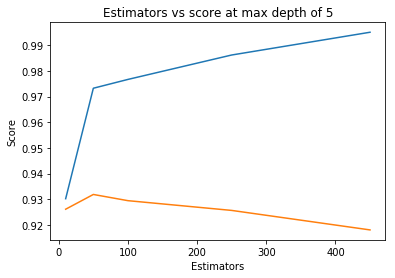

In [58]:
estimators = [10,50,100,250,450]
    
train_scores = []
test_scores = []
for i in tqdm_notebook(estimators):
    clf = LGBMClassifier(n_estimators=i, learning_rate=0.1, objective='binary', n_jobs=5, max_depth=5)
    clf.fit(df_final_train,y_train.to_numpy())
    train_sc = f1_score(y_train.to_numpy(),clf.predict(df_final_train))
    test_sc = f1_score(y_test.to_numpy(),clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at max depth of 5')

Estimators =  3 Train Score 0.9675080014584938 test Score 0.9231679986468773
Estimators =  9 Train Score 0.976970824319133 test Score 0.929155890956883
Estimators =  11 Train Score 0.9777293193611566 test Score 0.9319559752413545
Estimators =  15 Train Score 0.9779150516795867 test Score 0.929214220678849
Estimators =  20 Train Score 0.9778607844127002 test Score 0.9294289525503397
Estimators =  35 Train Score 0.9778607844127002 test Score 0.9294289525503397
Estimators =  50 Train Score 0.9778607844127002 test Score 0.9294289525503397
Estimators =  70 Train Score 0.9778607844127002 test Score 0.9294289525503397
Estimators =  130 Train Score 0.9778607844127002 test Score 0.9294289525503397



Text(0.5, 1.0, 'Depths vs score at estimators of 50')

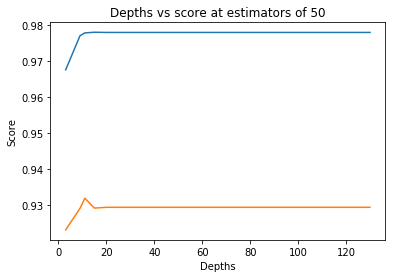

In [60]:
depths = [3,9,11,15,20,35,50,70,130]

train_scores = []
test_scores = []
for i in tqdm_notebook(depths):
    clf = LGBMClassifier(n_estimators=50, learning_rate=0.1, objective='binary', n_jobs=5, max_depth=i)
    clf.fit(df_final_train,y_train.to_numpy())
    train_sc = f1_score(y_train.to_numpy(),clf.predict(df_final_train))
    test_sc = f1_score(y_test.to_numpy(),clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depths')
plt.ylabel('Score')
plt.title('Depths vs score at estimators of 50')

In [61]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [78]:
#fitting the model with best parameters
clf = LGBMClassifier(n_estimators=50, learning_rate=0.1, objective='binary', n_jobs=5, max_depth=11)

clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [79]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9777293193611566
Test f1 score 0.9319559752413545


Train confusion_matrix


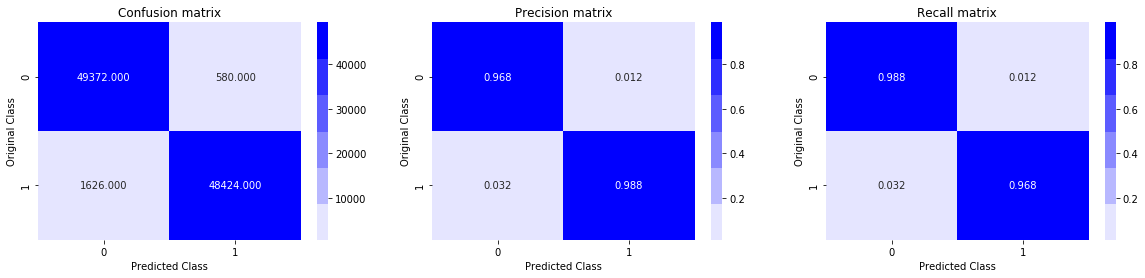

Test confusion_matrix


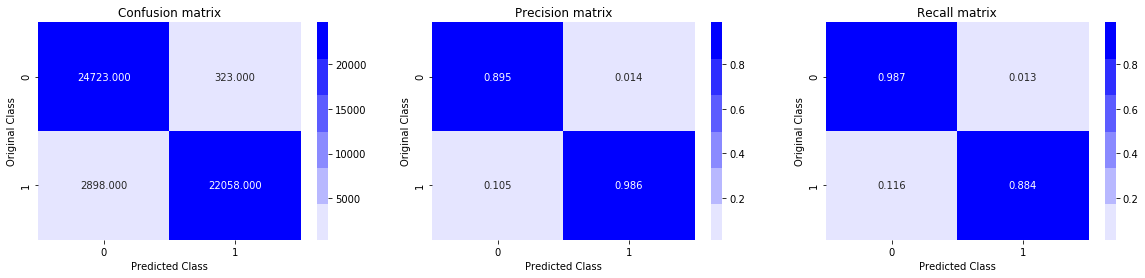

In [64]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

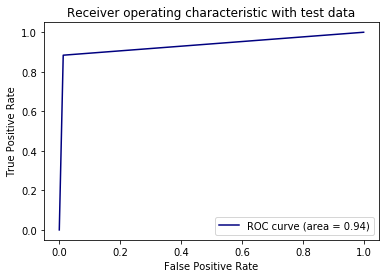

In [65]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

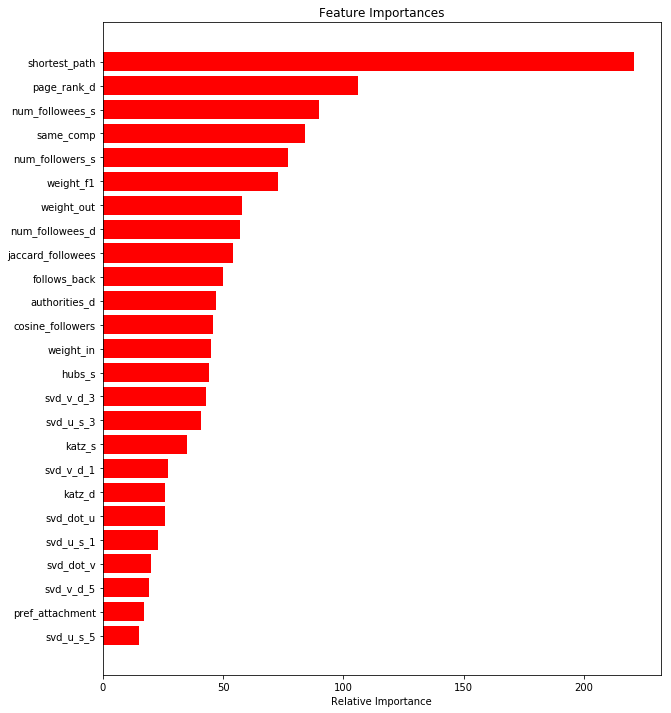

In [66]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Random Forest model

Estimators =  10 Train Score 0.916031808979149 test Score 0.8984278994872664
Estimators =  50 Train Score 0.9181232750689972 test Score 0.9133901221098569
Estimators =  100 Train Score 0.9190342245877469 test Score 0.9140351245305189
Estimators =  250 Train Score 0.9209657880446134 test Score 0.9158243509625468
Estimators =  450 Train Score 0.9214206576499361 test Score 0.9165564582152528


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

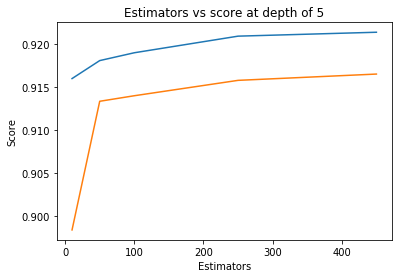

In [67]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8785540082561737 test Score 0.8593592195457377
depth =  9 Train Score 0.9563841300308333 test Score 0.9230996309963099
depth =  11 Train Score 0.9592785970911829 test Score 0.9244532384701202
depth =  15 Train Score 0.9620183598282074 test Score 0.9248459785635919
depth =  20 Train Score 0.9621656815569143 test Score 0.9252837193604184
depth =  35 Train Score 0.9620175929221538 test Score 0.925071681565188
depth =  50 Train Score 0.9620175929221538 test Score 0.925071681565188
depth =  70 Train Score 0.9620175929221538 test Score 0.925071681565188
depth =  130 Train Score 0.9620175929221538 test Score 0.925071681565188


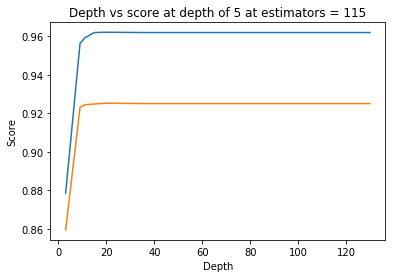

In [68]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [69]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96187661 0.96145871 0.95975427 0.96117622 0.96312084]
mean train scores [0.96275257 0.96229269 0.96033761 0.9618115  0.96401075]


In [70]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [71]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [72]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [73]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9643208786300841
Test f1 score 0.9266136162687888


In [74]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


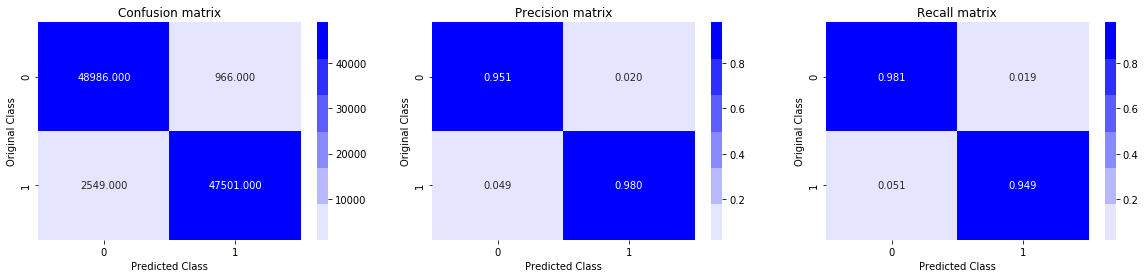

Test confusion_matrix


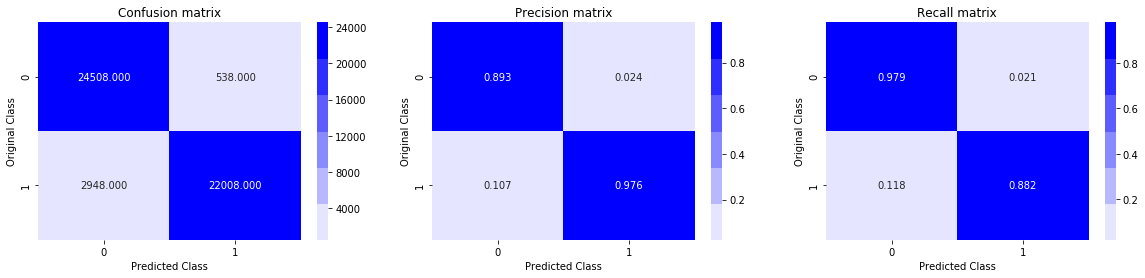

In [75]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

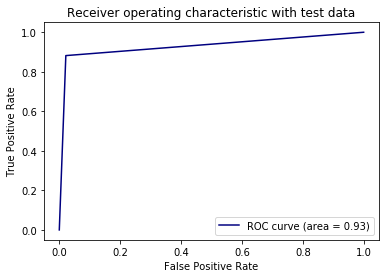

In [76]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

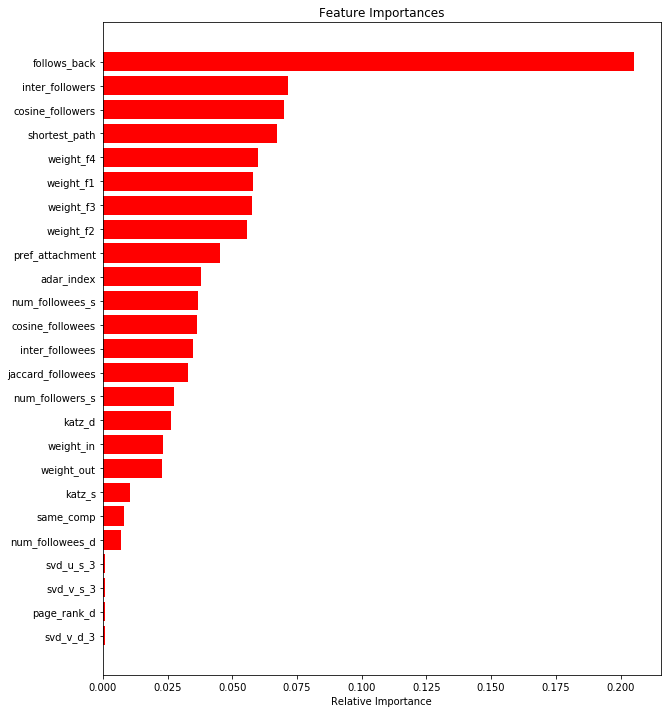

In [77]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Conclusion

 - The new features dot products and preferential attachment have fair amount of importance in XG Boost model
 - The dot product features aren't found as useful in Random Forest model
 - The XG Boost model (0.9319) has a slightly better test score than Random Forest model (0.9266)